In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
torch.__version__

'2.5.1'

In [5]:
pl.__version__

'2.5.1.post0'

In [6]:
# Setting dataset path
path = "E:\\mini_ImageNet\\archive\\"

In [7]:
#Using the previously calculated values (first notebook) of mean and std of the images in this dataset
mean = [0.4764, 0.4491, 0.4001]
std = [0.2264, 0.2224, 0.2212]

print("Mean:", mean)
print("Std:", std)

Mean: [0.4764, 0.4491, 0.4001]
Std: [0.2264, 0.2224, 0.2212]


### Image Transforms

In [8]:
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    
        transforms.RandomRotation(20),      # rotate +/- 20 degrees
        transforms.RandomHorizontalFlip(p=0.25),  # flip 24% of images
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                                       saturation=0.2)], p=0.5), # jitters by +/- given value
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3)
    ])
#https://docs.pytorch.org/vision/main/transforms.html

In [9]:
#Getting class names from the folder names of images
class_names=sorted(os.listdir(path))
class_names = ['_'.join(c.split('_')[:-1]) for c in class_names]

### Data Module

In [10]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size:int=32, num_workers:int=10, transform=transform):
        super().__init__()
        # self.root_dir = "/kaggle/input/miniimagenet"
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.num_w = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid
        
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])
        
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
        

### CNN Classifier

In [19]:
class ConvolutionalNetwork(pl.LightningModule):
    
    def __init__(self, class_labels, numChannels:int=3):
        super(ConvolutionalNetwork, self).__init__()
        
        #Initializing variable to collect grad norms 
        self._grad_norms = {}
        
        ##Initializing channel sizes for different layers
        
        self.conv1_out_channels = 16
        self.conv2_out_channels = 32
        self.conv3_out_channels = 64
        self.conv4_out_channels = 64
        
        self.fc1_out_features = 512
        self.fc2_out_features = 256
        self.fc3_out_features = len(class_labels)
        
        #Initializing lists to store train and val accuracies and losses
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []


        #First conv layer block
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=self.conv1_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1_out_channels)
        self.act1 = nn.ReLU()          #also try leaky relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Second conv layer block
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out_channels, out_channels=self.conv2_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.conv2_out_channels)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Third conv layer block
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out_channels, out_channels=self.conv3_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.conv3_out_channels)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Fourth conv layer block
        self.conv4 = nn.Conv2d(in_channels=self.conv3_out_channels, out_channels=self.conv4_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(self.conv4_out_channels)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Flatten
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.LazyLinear(self.fc1_out_features)    #try bias=True ?
        self.dropout1 = nn.Dropout(0.5)
        self.act_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=self.fc1_out_features, out_features=self.fc2_out_features)
        self.dropout2 = nn.Dropout(0.3)
        self.act_fc2 = nn.ReLU()
        
        self.fc3 = nn.Linear(in_features=self.fc2_out_features, out_features=self.fc3_out_features)
        self.output_activation  = nn.LogSoftmax(dim=1)
        
    # convolution output size formula: https://i.sstatic.net/vD1u3.png
    
    
    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.act4(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        x = self.dropout1(self.act_fc1(self.fc1(x)))
        x = self.dropout2(self.act_fc2(self.fc2(x)))
        x = self.output_activation(self.fc3(x))
        
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True),
            'monitor': 'val_loss'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss
    
    
    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        
        
    def on_train_epoch_end(self):
        train_acc = self.trainer.callback_metrics.get("train_acc")
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_acc is not None:
            self.training_accuracies.append(train_acc.item())
        if train_loss is not None:
            self.training_losses.append(train_loss.item())
        print(f"\nTrain - After Epoch {self.current_epoch}: loss={train_loss:.3f}, acc={train_acc:.3f}")
        
        #Calculating average grad norms
        vanished_count = 0
        exploded_count = 0
        total_layers = len(self._grad_norms)

        for name, norms in self._grad_norms.items():
            avg_norm = sum(norms) / len(norms)

            # Log to TensorBoard
            self.logger.experiment.add_scalar(f"grad_norm_epoch_avg/{name}", avg_norm, self.current_epoch)

            # Stats
            if avg_norm < 1e-6:
                vanished_count += 1
            elif avg_norm > 100:
                exploded_count += 1

        # Log total stats
        self.log("grad_stats/total_layers", total_layers, on_epoch=True)
        self.log("grad_stats/vanished", vanished_count, on_epoch=True)
        self.log("grad_stats/exploded", exploded_count, on_epoch=True)

        print(f"[Epoch {self.current_epoch}] Grad Norms — Total: {total_layers}, Vanished: {vanished_count}, Exploded: {exploded_count}")

        # Reset buffer
        self._grad_norms.clear()
    

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            self.validation_accuracies.append(val_acc.item())
        if val_loss is not None:
            self.validation_losses.append(val_loss.item())
        print(f"\nVal - After Epoch {self.current_epoch}: loss={val_loss:.3f}, acc={val_acc:.3f}")
    
    
    def on_train_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        for name, param in self.named_parameters():
            if param.grad is not None:
                norm = param.grad.norm().item()
                if name not in self._grad_norms:
                    self._grad_norms[name] = []
                self._grad_norms[name].append(norm)


In [20]:
#Removing the Validation DataLoader progress bar between epochs
class MinimalProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # Return a dummy tqdm with no visible output to disable validation progress bar
        # Set total=0 to avoid progress display
        return tqdm(disable=True)

    def init_test_tqdm(self):
        # Same for test dataloader
        return tqdm(disable=True)
    

In [21]:
#Setting seed to fetch the same training data every time
timestamp = datetime.now().strftime(format="%Y-%m-%d_%H-%M-%S")

In [22]:
#Configuring model checkpointing:
checkpoint_callback = ModelCheckpoint(
    dirpath=f"checkpoints\\{timestamp}",                   # Folder to save checkpoints
    filename=f"epoch{{epoch:02d}}-val_loss{{val_loss:.2f}}", 
    save_top_k=2,                             
    monitor="val_loss",                       # Metric to track best model
    mode="min",                               
    save_weights_only=False                  # Save full model
)

In [23]:
#Configuring early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",     # or "val_acc"
    patience=5,             # number of epochs to wait with no improvement
    mode="min",             # "min" for loss, "max" for accuracy
    verbose=True
)

In [24]:
# Create logger
logger = TensorBoardLogger("tensorboard_logs", name="miniimagenet_cnn")

In [25]:
#Setting seed to fetch the same training data every time
pl.seed_everything(42, workers=True)  # `workers=True` ensures worker-level reproducibility

Seed set to 42


42

### Model Training

In [26]:
datamodule = DataModule(batch_size=128)
datamodule.setup()
model = ConvolutionalNetwork(class_labels=class_names)
trainer = pl.Trainer(logger=logger,
                     callbacks=[MinimalProgressBar(), checkpoint_callback, early_stop_callback], 
                     default_root_dir="\\training_output", 
                     max_epochs=30)
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type        | Params | Mode 
-----------------------------------------------------------
0  | conv1             | Conv2d      | 448    | train
1  | bn1               | BatchNorm2d | 32     | train
2  | act1              | ReLU        | 0      | train
3  | pool1             | MaxPool2d   | 0      | train
4  | conv2             | Conv2d      | 4.6 K  | train
5  | bn2               | BatchNorm2d | 64     | train
6  | act2              | ReLU        | 0      | train
7  | pool2             | MaxPool2d   | 0      | train
8  | conv3             | Conv2d      | 18.5 K | train
9  | bn3               | BatchNorm2d | 128    | train
10 | act3              | ReLU        | 0      | train
11 | pool3             | MaxPool2d   | 0      | train
12 | conv4             | Conv2d      | 36.9 K | train
13 | bn4               | 

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]
Val - After Epoch 0: loss=3.911, acc=0.039
Epoch 0: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:18<00:00,  2.11it/s, v_num=1]
Val - After Epoch 0: loss=3.569, acc=0.095
Epoch 0: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:39<00:00,  1.65it/s, v_num=1]

Metric val_loss improved. New best score: 3.569



Train - After Epoch 0: loss=3.799, acc=0.050
[Epoch 0] Grad Norms — Total: 22, Vanished: 4, Exploded: 0
Epoch 1: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.20it/s, v_num=1]
Val - After Epoch 1: loss=3.417, acc=0.125
Epoch 1: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:36<00:00,  1.71it/s, v_num=1]

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 3.417



Train - After Epoch 1: loss=3.598, acc=0.079
[Epoch 1] Grad Norms — Total: 22, Vanished: 4, Exploded: 0
Epoch 2: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.18it/s, v_num=1]
Val - After Epoch 2: loss=3.390, acc=0.120
Epoch 2: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:36<00:00,  1.70it/s, v_num=1]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 3.390



Train - After Epoch 2: loss=3.512, acc=0.095
[Epoch 2] Grad Norms — Total: 22, Vanished: 4, Exploded: 0
Epoch 3: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.18it/s, v_num=1]
Val - After Epoch 3: loss=3.366, acc=0.135
Epoch 3: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:36<00:00,  1.72it/s, v_num=1]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 3.366



Train - After Epoch 3: loss=3.443, acc=0.110
[Epoch 3] Grad Norms — Total: 22, Vanished: 4, Exploded: 0
Epoch 4: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.27it/s, v_num=1]
Val - After Epoch 4: loss=3.319, acc=0.140
Epoch 4: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=1]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 3.319



Train - After Epoch 4: loss=3.397, acc=0.117
[Epoch 4] Grad Norms — Total: 22, Vanished: 4, Exploded: 0
Epoch 5: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.24it/s, v_num=1]
Val - After Epoch 5: loss=3.303, acc=0.142
Epoch 5: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.75it/s, v_num=1]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 3.303



Train - After Epoch 5: loss=3.345, acc=0.127
[Epoch 5] Grad Norms — Total: 22, Vanished: 4, Exploded: 0
Epoch 6: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.22it/s, v_num=1]
Val - After Epoch 6: loss=3.242, acc=0.166
Epoch 6: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.74it/s, v_num=1]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 3.242



Train - After Epoch 6: loss=3.306, acc=0.136
[Epoch 6] Grad Norms — Total: 22, Vanished: 4, Exploded: 0
Epoch 7: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.27it/s, v_num=1]
Val - After Epoch 7: loss=3.171, acc=0.176
Epoch 7: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=1]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 3.171



Train - After Epoch 7: loss=3.263, acc=0.144
[Epoch 7] Grad Norms — Total: 22, Vanished: 4, Exploded: 0
Epoch 8: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=1]
Val - After Epoch 8: loss=3.143, acc=0.190
Epoch 8: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.74it/s, v_num=1]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 3.143



Train - After Epoch 8: loss=3.230, acc=0.157
[Epoch 8] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 9: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.24it/s, v_num=1]
Val - After Epoch 9: loss=3.184, acc=0.179
Epoch 9: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.74it/s, v_num=1]
Train - After Epoch 9: loss=3.204, acc=0.159
[Epoch 9] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 10: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=1]
Val - After Epoch 10: loss=3.136, acc=0.191
Epoch 10: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=1]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 3.136



Train - After Epoch 10: loss=3.164, acc=0.166
[Epoch 10] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 11: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.24it/s, v_num=1]
Val - After Epoch 11: loss=3.114, acc=0.200
Epoch 11: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:35<00:00,  1.74it/s, v_num=1]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 3.114



Train - After Epoch 11: loss=3.131, acc=0.175
[Epoch 11] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 12: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.26it/s, v_num=1]
Val - After Epoch 12: loss=3.050, acc=0.225
Epoch 12: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=1]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 3.050



Train - After Epoch 12: loss=3.114, acc=0.178
[Epoch 12] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 13: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=1]
Val - After Epoch 13: loss=3.032, acc=0.208
Epoch 13: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=1]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 3.032



Train - After Epoch 13: loss=3.084, acc=0.183
[Epoch 13] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 14: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.22it/s, v_num=1]
Val - After Epoch 14: loss=3.095, acc=0.200
Epoch 14: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:35<00:00,  1.73it/s, v_num=1]
Train - After Epoch 14: loss=3.051, acc=0.197
[Epoch 14] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 15: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.26it/s, v_num=1]
Val - After Epoch 15: loss=3.000, acc=0.220
Epoch 15: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=1]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 3.000



Train - After Epoch 15: loss=3.033, acc=0.195
[Epoch 15] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 16: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=1]
Val - After Epoch 16: loss=2.920, acc=0.232
Epoch 16: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=1]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 2.920



Train - After Epoch 16: loss=3.001, acc=0.202
[Epoch 16] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 17: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.23it/s, v_num=1]
Val - After Epoch 17: loss=2.915, acc=0.233
Epoch 17: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.74it/s, v_num=1]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 2.915



Train - After Epoch 17: loss=2.978, acc=0.208
[Epoch 17] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 18: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=1]
Val - After Epoch 18: loss=2.907, acc=0.248
Epoch 18: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=1]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 2.907



Train - After Epoch 18: loss=2.944, acc=0.216
[Epoch 18] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 19: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=1]
Val - After Epoch 19: loss=2.838, acc=0.263
Epoch 19: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=1]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 2.838



Train - After Epoch 19: loss=2.940, acc=0.217
[Epoch 19] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 20: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.29it/s, v_num=1]
Val - After Epoch 20: loss=2.830, acc=0.264
Epoch 20: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=1]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 2.830



Train - After Epoch 20: loss=2.906, acc=0.226
[Epoch 20] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 21: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=1]
Val - After Epoch 21: loss=2.862, acc=0.258
Epoch 21: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.75it/s, v_num=1]
Train - After Epoch 21: loss=2.886, acc=0.230
[Epoch 21] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 22: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.21it/s, v_num=1]
Val - After Epoch 22: loss=2.778, acc=0.269
Epoch 22: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:35<00:00,  1.72it/s, v_num=1]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 2.778



Train - After Epoch 22: loss=2.867, acc=0.233
[Epoch 22] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 23: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.26it/s, v_num=1]
Val - After Epoch 23: loss=2.793, acc=0.275
Epoch 23: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=1]
Train - After Epoch 23: loss=2.845, acc=0.240
[Epoch 23] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 24: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.24it/s, v_num=1]
Val - After Epoch 24: loss=2.750, acc=0.280
Epoch 24: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=1]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 2.750



Train - After Epoch 24: loss=2.828, acc=0.246
[Epoch 24] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 25: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.32it/s, v_num=1]
Val - After Epoch 25: loss=2.781, acc=0.266
Epoch 25: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=1]
Train - After Epoch 25: loss=2.802, acc=0.246
[Epoch 25] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 26: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=1]
Val - After Epoch 26: loss=2.673, acc=0.300
Epoch 26: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=1]

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 2.673



Train - After Epoch 26: loss=2.783, acc=0.259
[Epoch 26] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 27: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.32it/s, v_num=1]
Val - After Epoch 27: loss=2.730, acc=0.284
Epoch 27: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=1]
Train - After Epoch 27: loss=2.765, acc=0.260
[Epoch 27] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 28: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.32it/s, v_num=1]
Val - After Epoch 28: loss=2.686, acc=0.292
Epoch 28: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=1]
Train - After Epoch 28: loss=2.741, acc=0.262
[Epoch 28] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 29: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.17it/s, v_

`Trainer.fit` stopped: `max_epochs=30` reached.



Train - After Epoch 29: loss=2.720, acc=0.268
[Epoch 29] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 29: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:37<00:00,  1.70it/s, v_num=1]


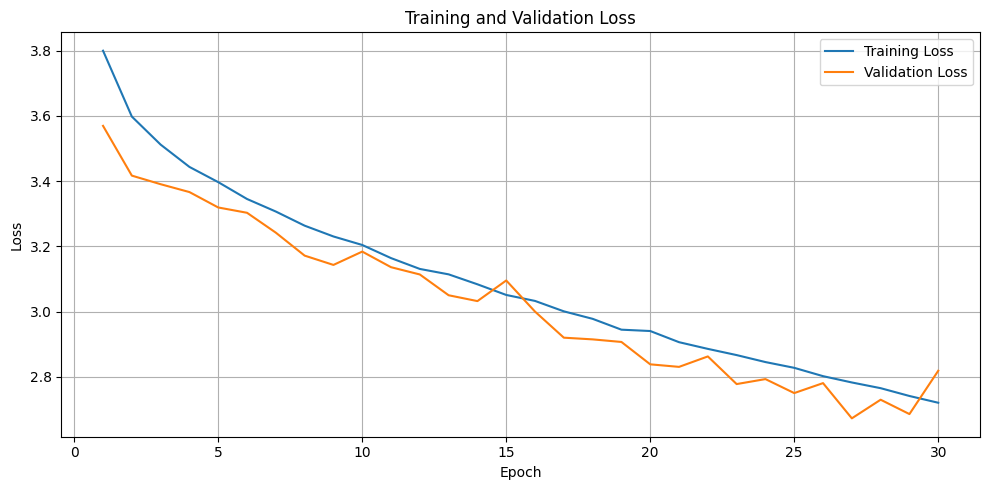

In [27]:
#Plotting train and validation loss
epochs = range(1, len(model.training_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, model.training_losses, label='Training Loss')
plt.plot(epochs, model.validation_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

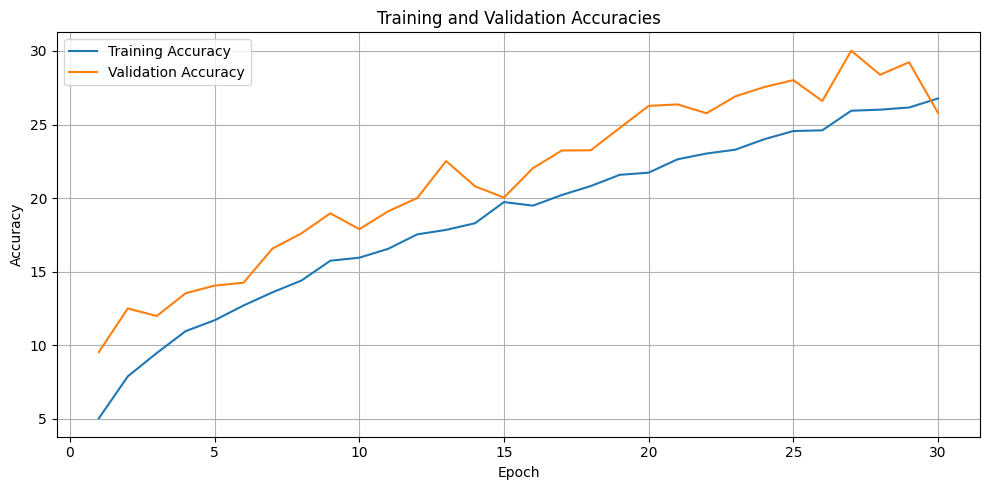

In [28]:
#Plotting train and validation accuracy
epochs = range(1, len(model.training_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, [a*100 for a in model.training_accuracies], label='Training Accuracy')
plt.plot(epochs, [a*100 for a in model.validation_accuracies[1:]], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()